# BERT text classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tokenizers import (
    normalizers,
    pre_tokenizers,
    trainers,
    SentencePieceBPETokenizer
)
from tokenizers.processors import TemplateProcessing
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import transformers
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast
from transformers import AutoTokenizer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import altair as alt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
torch.set_float32_matmul_precision("high")

In [4]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [5]:
from datasets import load_dataset
ds = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [57]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [13]:
ds['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [6]:
train = pd.DataFrame(ds['train'])
test = pd.DataFrame(ds['test'])

In [7]:
X_train, X_test, y_train, y_test =  train['text'], test['text'], train['label'], test['label']

In [8]:
X_train, X_val, y_train, y_val =  train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.1, random_state=42)

In [9]:
assert(len(y_test) == len(X_test))

In [14]:
LOWERCASE = False
VOCAB_SIZE = 20000

In [15]:
raw_tokenizer = SentencePieceBPETokenizer()

raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

special_tokens = ["<unk>", "<pad>", "<cls>", "<sep>", "<mask>",]

In [16]:
def train_corp_iter(X_train):
    """
    A generator function for iterating over a dataset in chunks.
    """
    for i in range(0, len(X_train), 1000):
        yield X_train[i : i + 1000]


raw_tokenizer.train_from_iterator(train_corp_iter(X_train), vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

In [17]:
raw_tokenizer.token_to_id("<cls>"), raw_tokenizer.token_to_id("<sep>"), raw_tokenizer.token_to_id("<pad>")

(2, 3, 1)

In [20]:
raw_tokenizer.post_processor = TemplateProcessing(
        single="<cls> $A <sep>",
        pair="<cls> $A <sep> $B <sep>",
        special_tokens=[
            ("<cls>", raw_tokenizer.token_to_id("<cls>")),
            ("<sep>", raw_tokenizer.token_to_id("<sep>")),
        ],
    )

In [21]:
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object = raw_tokenizer,
    unk_token= "<unk>",
    pad_token= "<pad>",
    cls_token= "<cls>",
    sep_token= "<sep>",
    mask_token="<mask>",
)


In [22]:
X_train_tokenized_with_att   = tokenizer(X_train.tolist())
X_val_tokenized_with_att     = tokenizer(X_val.tolist())
X_test_tokenized_with_att    = tokenizer(X_test.tolist())

In [23]:
tokenizer.tokenize("Attention Is All You Need")

['Att', 'ention', 'ĠIs', 'ĠAll', 'ĠYou', 'ĠNeed']

In [24]:
tokenizer("Attention Is All You Need")

{'input_ids': [2, 17043, 936, 1768, 1229, 950, 7788, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [25]:
tokenizer("Attention Is All You Need", "But you could want more")

{'input_ids': [2, 17043, 936, 1768, 1229, 950, 7788, 3, 2012, 267, 520, 630, 420, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [27]:
tokenizer.decode( [2, 17043, 936, 1768, 1229, 950, 7788, 3, 2012, 267, 520, 630, 420, 3])

'<cls>AttentionĠIsĠAllĠYouĠNeed<sep>ButĠyouĠcouldĠwantĠmore<sep>'

In [28]:
tokenizer("Hello")

{'input_ids': [2, 44, 10060, 3], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [29]:
tokenizer("Attention")

{'input_ids': [2, 17043, 936, 3], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [30]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


## Bert

In [31]:
cm = torch.tril(torch.ones(5, 5)).view(1, 1, 5, 5)
cm

tensor([[[[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]]]])

In [32]:
cm.masked_fill(cm[:, :, :5, :5] == 0, float('-inf'))

tensor([[[[1., -inf, -inf, -inf, -inf],
          [1., 1., -inf, -inf, -inf],
          [1., 1., 1., -inf, -inf],
          [1., 1., 1., 1., -inf],
          [1., 1., 1., 1., 1.]]]])

In [33]:
tensor = torch.ones([1, 4])
tensor[:, None, None, :]

tensor([[[[1., 1., 1., 1.]]]])

In [34]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        # D: d_model i.e. model size
        # d_v: value head size
        # d_k: key head size
        # h: n_heads
        super().__init__()
        d_k = d_model // n_heads
        self.d_k = d_k
        self.n_heads = n_heads

        self.key = nn.Linear(d_model, d_k * n_heads)
        self.query = nn.Linear(d_model, d_k * n_heads)
        self.value = nn.Linear(d_model, d_k * n_heads)

        self.fc = nn.Linear(d_k * n_heads, d_model)

    def forward(self, q, k, v, mask=None):
        # D: d_model i.e. model size
        # N: n_samples
        # d_v: value head size
        # d_k: key head size
        # h: n_heads
        # T: seq_len i.e. time steps
        # Assume d_v = d_k
        # q, k, v: shape # N x T x D
        q = self.query(q) # N x T x (h * d_k)
        k = self.key(k)   # N x T x (h * d_k)
        v = self.value(v) # N x T x (h * d_v)

        N = q.shape[0]
        T = q.shape[1]

        # change the shape to:
        # (N, T, h, d_k) -> (N, h, T, d_k)
        q = q.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T, self.n_heads, self.d_k).transpose(1, 2)

        # compute attention weights
        # (N, h, T, d_k) x (N, h, d_k, T) --> (N, h, T, T)
        # for i in [1...N]:
        #     for j in [1...h]:
        #           T, d_k @ d_k, T -> T x T
        attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(
                mask[:, None, None, :] == 0, -10000)
        attn_weights = F.softmax(attn_scores, dim=-1)

        # compute attention-weighted values
        # (N, h, T, T) x (N, h, T, d_k) --> (N, h, T, d_k)
        A = attn_weights @ v

        # reshape it back before final linear layer
        A = A.transpose(1, 2) # (N, T, h, d_k)
        A = A.contiguous().view(N, T, self.d_k * self.n_heads) # (N, T, h * d_k)

        return self.fc(A)

In [35]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout_prob),
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, mask=None):
        x = self.ln1(x + self.mha(x, x, x, mask))
        x = self.ln2(x + self.ann(x))
        x = self.dropout(x)
        return x

In [36]:
torch.arange(5).unsqueeze(1)

tensor([[0],
        [1],
        [2],
        [3],
        [4]])

In [37]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout_prob=0.1):
        # N: n_samples
        # T: seq_len i.e. time steps
        # D: d_model i.e. model size
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        position = torch.arange(max_len).unsqueeze(1)
        # possition.shape: 1 x T
        exp_term = torch.arange(0, d_model, 2)
        div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        # pe.shape: 1 x T x D
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x.shape: N x T x D
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [38]:
pe = PositionalEncoding(4)

pe(torch.ones([1, 8, 4]))

tensor([[[1.1111, 2.2222, 1.1111, 2.2222],
         [0.0000, 1.7114, 1.1222, 2.2222],
         [2.1214, 0.6487, 1.1333, 2.2220],
         [1.2679, 0.0111, 1.1444, 2.2217],
         [0.0000, 0.3848, 1.1555, 2.2213],
         [0.0456, 1.4263, 1.1666, 2.2208],
         [0.8006, 2.1780, 1.1777, 2.2202],
         [1.8411, 1.9488, 1.1888, 2.2195]]])

In [39]:
def example_positional():
    pe = PositionalEncoding(20, max_len=100, dropout_prob=0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )

example_positional()

alt.Chart(...)

In [41]:
class Encoder(nn.Module):
    def __init__(self,
                   vocab_size,
                   max_len,
                   d_model,
                   n_heads,
                   n_layers,
                   n_classes,
                   dropout_prob):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformer_blocks = [
            TransformerBlock(
                d_model,
                n_heads,
                dropout_prob) for _ in range(n_layers)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x, mask=None):
        # N: n_samples
        # T: seq_len i.e. time steps
        # D: d_model i.e. model size
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
          x = block(x, mask)
        # x.shape: N x T x D
        x = x[:, 0, :]
        # x.shape: N x 1 x D

        x = self.ln(x)
        x = self.fc(x)
        return x

In [47]:
def data_generator(X, y, max_len=512, batch_size=32, shuffle_data=True, pad_token_id=tokenizer.pad_token_id):

    input_ids = X['input_ids']
    att_mask = X['attention_mask']

    if shuffle_data:
        input_ids, att_mask, y = shuffle(input_ids, att_mask, y)

    n_batches = int(np.ceil(len(y) / batch_size))

    for batch in range(n_batches):
        end = min((batch + 1) * batch_size, len(y))

        input_ids_batch = input_ids[batch * batch_size:end]
        att_mask_batch = att_mask[batch * batch_size:end]
        y_batch = y[batch * batch_size:end]

        batch_max_len = np.max([len(x) for x in input_ids_batch])
        batch_max_len = np.min([batch_max_len, max_len])

        for sample in range(len(input_ids_batch)):
            x = input_ids_batch[sample]
            if len(x) > batch_max_len:
                x = x[:batch_max_len]
            pad = [pad_token_id] * (batch_max_len - len(x))
            input_ids_batch[sample] = x + pad

            x = att_mask_batch[sample]
            if len(x) > batch_max_len:
                x = x[:batch_max_len]
            pad = [0] * (batch_max_len - len(x))
            att_mask_batch[sample] = x + pad

        input_ids_batch = torch.from_numpy(np.array(input_ids_batch)).long()
        att_mask_batch = torch.from_numpy(np.array(att_mask_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        yield input_ids_batch, att_mask_batch, y_batch

In [48]:
train_gen   = lambda : data_generator(X_train_tokenized_with_att, y_train.tolist())
val_gen     = lambda : data_generator(X_val_tokenized_with_att  , y_val.tolist(), shuffle_data=False)
test_gen    = lambda : data_generator(X_test_tokenized_with_att , y_test.tolist(), shuffle_data=False)

In [49]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss, train_acc = 0, 0
    steps = 0

    for input_ids, att_mask, y in data_loader():
        y = y.view(-1, 1).float()
        input_ids, att_mask, y = input_ids.to(device), att_mask.to(device), y.to(device)

        y_pred = model(input_ids, att_mask)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        train_acc += accuracy_fn(y_true=y.squeeze(1), y_pred=(y_pred.squeeze(1) > 0))
        steps += 1

    return train_loss / steps, train_acc / steps


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0
    steps = 0

    with torch.inference_mode():
        for input_ids, att_mask, y in data_loader():
            y = y.view(-1, 1).float()
            input_ids, att_mask, y = input_ids.to(device), att_mask.to(device), y.to(device)

            y_pred = model(input_ids, att_mask)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y.squeeze(1), y_pred=(y_pred.squeeze(1) > 0))
            steps += 1

    return test_loss / steps, test_acc / steps

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results

In [50]:
for input_ids, att_mask, y in train_gen():
    print(input_ids.shape, att_mask.shape, y.shape)
    break

torch.Size([32, 512]) torch.Size([32, 512]) torch.Size([32])


## Bert

In [51]:
tokenizer.vocab_size

20000

Encoder(
  (embedding): Embedding(20000, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
        (3): Dropout(p=0.3, inplace=False)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6034 | train_acc: 66.0511 | test_loss: 0.6083 | test_acc: 73.6551 | time: 33.5671
Epoch: 2 | train_loss: 0.4183 | train_acc: 81.3255 | test_loss: 0.3701 | test_acc: 84.2563 | time: 31.2640
Epoch: 3 | train_loss: 0.3416 | train_acc: 85.8310 | test_loss: 0.3293 | test_acc: 86.1155 | time: 31.1660
Epoch: 4 | train_loss: 0.2998 | train_acc: 87.7708 | test_loss: 0.3652 | test_acc: 86.5902 | time: 31.3554
Epoch: 5 | train_loss: 0.2615 | train_acc: 89.7550 | test_loss: 0.3379 | test_acc: 87.1440 | time: 32.0520


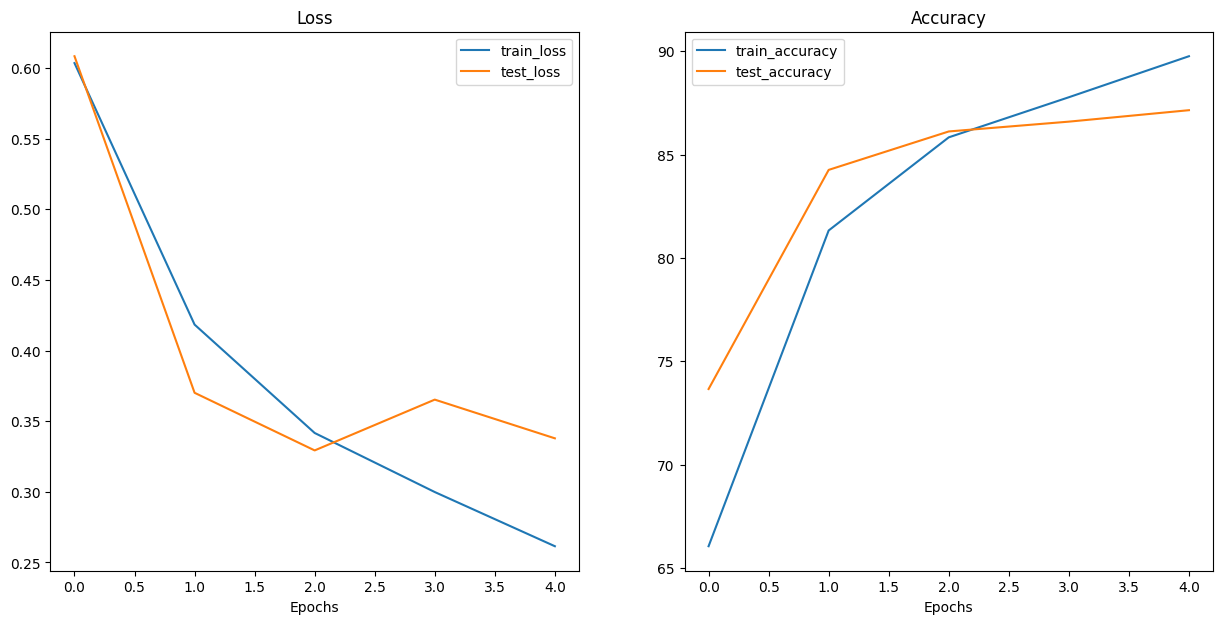

In [52]:
model = Encoder(
    vocab_size=tokenizer.vocab_size,
    max_len=512,
    d_model=64,
    n_heads=4,
    n_layers=2,
    n_classes=1,
    dropout_prob=0.3
)
model.to(device)

print(model)

loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=2e-5)

results = train(model=model,
          train_data_loader = train_gen,
          test_data_loader = val_gen,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 5,
          device = device)

plot_loss_curves(results)

## Bert fine tune

In [ ]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()
        self.bert_model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.fc = nn.Linear(768, 1)

    def forward(self, ids, mask):
        x = self.bert_model(ids, attention_mask=mask, return_dict=False)[0]
        # x.shape: N x T x D
        x = x[:, 0, :]
        # x.shape: N x 1 x D
        x = self.fc(x)

        return x

In [53]:
model_name = "distilbert-base-uncased"
tokenizer_distill_bert = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [54]:
tokenizer_distill_bert("Hello")

{'input_ids': [101, 7592, 102], 'attention_mask': [1, 1, 1]}

In [55]:
tokenizer_distill_bert.decode([101, 7592, 102])

'[CLS] hello [SEP]'

In [56]:
tokenizer_distill_bert("Hello", "how are you")

{'input_ids': [101, 7592, 102, 2129, 2024, 2017, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
X_train_tokenized_distill_bert   = tokenizer_distill_bert(X_train.tolist())
X_val_tokenized_distill_bert      = tokenizer_distill_bert(X_val.tolist())
X_test_tokenized_distill_bert     = tokenizer_distill_bert(X_test.tolist())

Token indices sequence length is longer than the specified maximum sequence length for this model (753 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
train_gen_distill_bert   = lambda : data_generator(X_train_tokenized_distill_bert, y_train.tolist(), batch_size=16, pad_token_id=tokenizer_distill_bert.pad_token_id)
val_gen_distill_bert     = lambda : data_generator(X_val_tokenized_distill_bert  , y_val.tolist(), batch_size=16, pad_token_id=tokenizer_distill_bert.pad_token_id, shuffle_data=False)
test_gen_distill_bert    = lambda : data_generator(X_test_tokenized_distill_bert , y_test.tolist(), batch_size=16, pad_token_id=tokenizer_distill_bert.pad_token_id, shuffle_data=False)

BERT(
  (bert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_f

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2668 | train_acc: 89.2902 | test_loss: 0.2327 | test_acc: 91.7596 | time: 1004.4229
Epoch: 2 | train_loss: 0.1565 | train_acc: 95.2559 | test_loss: 0.2449 | test_acc: 92.8742 | time: 999.5027


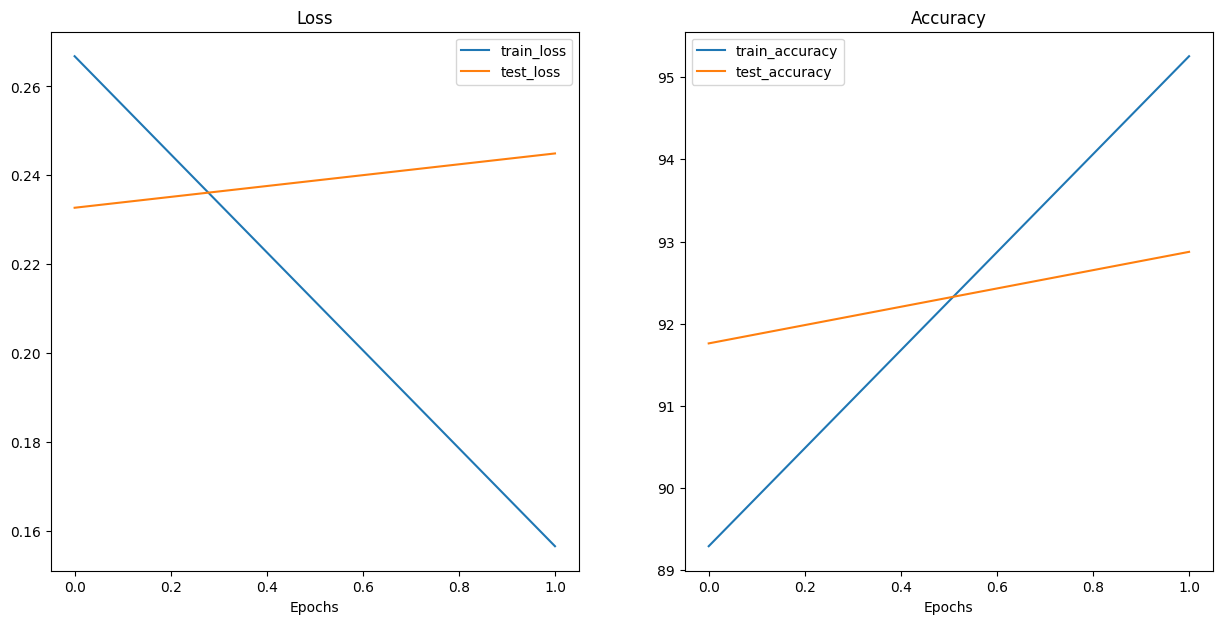

In [ ]:
model_2 = BERT()
model_2.to(device)

print(model_2)

loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=3e-5, weight_decay=2e-5)


results = train(model=model_2,
          train_data_loader = train_gen_distill_bert,
          test_data_loader = val_gen_distill_bert,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 2,
          device = device)

plot_loss_curves(results)

## Testing

In [ ]:
loss = nn.BCEWithLogitsLoss()

In [ ]:
def test_model(model, test_gen, loss, device, test_step=test_step):
    start_time = timer()
    loss, acc = test_step(model, test_gen, loss, device)
    end_time = timer()
    print('loss:', loss)
    print('accuracy:', acc)
    print('time:', end_time - start_time)
    print('-----------------------------')


In [ ]:
test_model(model, test_gen, loss, device, test_step)
test_model(model_2, test_gen_distill_bert, loss, device, test_step)

loss: 0.3709722341650435
accuracy: 85.94549232736573
time: 14.325538249000147
-----------------------------
loss: 0.22713730936710289
accuracy: 93.01023672424824
time: 343.5202053889998
-----------------------------


In [ ]:
def get_predicted_labels(model,
              data_generator,
              loss_fn,
              device):
    model.eval()

    test_pred_labels = []

    with torch.inference_mode():
        for input_ids, att_mask, y in data_generator():
            y = y.view(-1, 1).float()
            input_ids, att_mask, y = input_ids.to(device), att_mask.to(device), y.to(device)

            test_pred_logits = model(input_ids, att_mask)

            loss = loss_fn(test_pred_logits, y)

            test_pred_labels += test_pred_logits > 0

    return test_pred_labels

In [ ]:
test_pred_labels = get_predicted_labels(model_2, test_gen_distill_bert, loss, device)

In [ ]:
test_pred_labels_cpu = list(map(lambda x : x.cpu(), test_pred_labels))

In [ ]:
test_pred_labels_cpu = list(map(lambda x : int(x[0].item()), test_pred_labels_cpu))

In [ ]:
test_texts = pd.DataFrame(ds['test'])['text']

In [ ]:
miss_classifications = pd.DataFrame(
    {
    'text' : list(test_texts[test_pred_labels_cpu != y_test]),
    'true label' : y_test[test_pred_labels_cpu != y_test],
    'predicted label' : np.array(test_pred_labels_cpu)[test_pred_labels_cpu != y_test]
    })

In [ ]:
pp = pprint.PrettyPrinter()

In [ ]:
def printMissClassifications(df):
    index = random.choice(miss_classifications.index)
    pp.pprint(miss_classifications.loc[index].text)
    print(f"True label ", miss_classifications.loc[index]['true label'])
    print("Predicted  label ", miss_classifications.loc[index]['predicted label'])

In [ ]:
printMissClassifications(miss_classifications)

('This movie is all about blaxploitation, there is absolutely no plot at all. '
 'A pimp stops some bad guys with his kung fu hoes to try to get his nightclub '
 'back. Rated R for Strong Language, and a brief sexual situation.')
True label  1
Predicted  label  0


In [ ]:
printMissClassifications(miss_classifications)

("After watching Ingmar Bergman's Skammen, I had many feelings, but most "
 'notably, I felt unsatisfied. I have heard so much hype about this movie but '
 "I came to find it lacking. Don't get me wrong, I can fully appreciate the "
 'artistic value of such a film, but as far as depth and emotion, I was not so '
 'impressed. I found the characters to be disagreeable and unrealistic, which '
 'detracted from the dramatic effect. In addition, the fact that the war was '
 'fake led me to feel that the emotion was not real. Dramatic war movies, in '
 'my opinion, are much more effective if the events (not necessarily the story '
 'itself) really happened. I find that of all the movies that try to show the '
 'brutality this one falls in the middle as far as effectiveness.')
True label  1
Predicted  label  0


In [ ]:
printMissClassifications(miss_classifications)

('The greatest compliments to the other commentator here at IMDb who asked '
 'himself why this series didn\'t "get stuck" in its time to last a lot longer '
 'like many other series in the 80s did.<br /><br />It is not true the series '
 'would have gotten worse if further continued.<br /><br />I will at the end '
 'of this my comment post some thoughts about the other movie realizations, '
 'rather: attempts of the Robin Hood legend.<br /><br />First of All, Robert '
 'Addie (Gisburne), you are among us all, you live forever.<br /><br />Nothing '
 'is as fun as the entire two, if one wants, three seasons of this absolutely '
 'unique series. And at the same time absolutely agreeing with the mostly new '
 "and revolutionary findings of Terry Jones' history documentations about "
 'Egypt, Greece, Rome, Konstantinopel, the Goths and Barbarians, and the '
 'middle ages and crusades (...yes, THE Monthy Python-Terry Jones):<br /><br '
 '/>If you have seen those brilliant and funny Jones-Do